# Create Ground Truth

In [211]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

from datetime import date

In [85]:
def GroundTruthModel(gamma_shift=0., C=0.):
    gamma_shift = torch.tensor(gamma_shift)
    C = torch.tensor(C)
    
    lambda1 = torch.tensor(0.2)
    lambda2 = torch.tensor(-0.1)
    lambda3 = torch.tensor(-0.8)
    lambda4 = torch.tensor(0.8)

    lambda5 = torch.tensor(0.8)
    lambda6 = torch.tensor(0.1)
    lambda7 = torch.tensor(-0.8)
    lambda8 = torch.tensor(0.2)
    
    u1 = pyro.sample("u1", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
    u2 = pyro.sample("u2", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
    u3 = pyro.sample("u3", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
    u4 = pyro.sample("u4", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    
    a_prob = torch.sigmoid(gamma_shift * lambda1 * C + u1)
    a_val = pyro.sample("a", dist.Bernoulli(probs=a_prob))
    a = pyro.sample("A", dist.Delta(a_val))
    
    r_val = pyro.sample("r", dist.Normal(0., 1.)) + lambda2 * a_val + u2 
    r = pyro.sample("R", dist.Delta(r_val))
    
    y_prob = torch.sigmoid(lambda3 * a_val + lambda4 * r_val + u3)
    y_val = pyro.sample("y", dist.Bernoulli(y_prob))
    y = pyro.sample("Y", dist.Delta(y_val))
    
    t_val = pyro.sample("t", dist.Normal(lambda5 * y_val + lambda6 * r_val + lambda7 * a_val + u4, 1. + gamma_shift * lambda8 * C))
    t = pyro.sample("T", dist.Delta(t_val))

In [86]:
trace_handler = pyro.poutine.trace(GroundTruthModel)
samples = pd.DataFrame(columns=['A', 'R', 'T', 'Y'])
sample_noise = pd.DataFrame(columns=['u1', 'u2', 'u3', 'u4'])

In [87]:
num_samples = 2000
all_samples=[]

for i in range(num_samples):
    trace = trace_handler.get_trace()
    a = trace.nodes['A']['value'].numpy().item()
    r = trace.nodes['R']['value'].numpy().item()
    t = trace.nodes['T']['value'].numpy().item()
    y = trace.nodes['Y']['value'].numpy().item()
    
    u1 = trace.nodes['u1']['value'].numpy().item()
    u2 = trace.nodes['u2']['value'].numpy().item()
    u3 = trace.nodes['u3']['value'].numpy().item()
    u4 = trace.nodes['u4']['value'].numpy().item()

    samples = samples.append({'A': a, 'R': r, 'T': t, 'Y':y}, ignore_index=True)
    sample_noise = sample_noise.append({'u1': u1, 'u2': u2, 'u3': u3, 'u4':u4}, ignore_index=True)

samples.head()

,A,R,T,Y
0,1.0,1.258748,-2.364303,0.0
1,0.0,0.873463,3.079657,1.0
2,1.0,0.430376,0.754667,1.0
3,1.0,1.406423,-0.150041,1.0
4,1.0,-0.234543,1.117481,0.0


/home/zainkhan/miniconda3/envs/digbio/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'R'}>],
       [<AxesSubplot:title={'center':'T'}>,
        <AxesSubplot:title={'center':'Y'}>]], dtype=object)

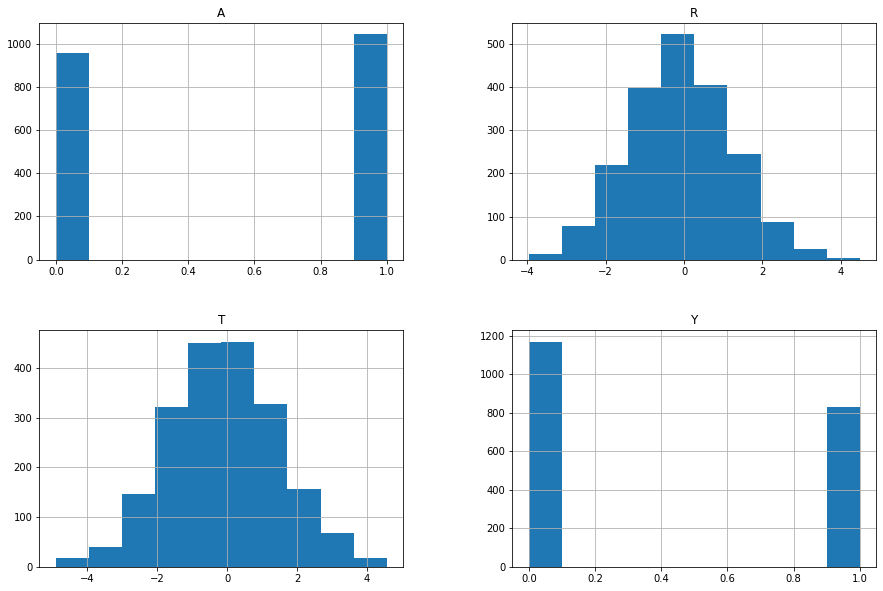

In [88]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)

samples.hist()

In [256]:
date_time = date.today().strftime('%m-%d-%Y')
#samples.to_csv(f'{date_time}-src-groundtruth.csv', index=False)
#sample_noise.to_csv(f'{date_time}-src-groundtruth-noise.csv', index=False)

samples = pd.read_csv(f'{date_time}-src-groundtruth.csv')
samples.head()

,A,R,T,Y
0,1.0,1.258748,-2.364303,0.0
1,0.0,0.873463,3.079657,1.0
2,1.0,0.430376,0.754667,1.0
3,1.0,1.406423,-0.150041,1.0
4,1.0,-0.234543,1.117481,0.0


# Learn Parameters from Ground Truth

In [90]:
def ProposedModel(data, gamma_shift=0., C=0.):
    gamma_shift = torch.tensor(gamma_shift)
    C = torch.tensor(C)

    lambda1 = pyro.sample("lambda1", dist.Normal(0., 1.))
    lambda2 = pyro.sample("lambda2", dist.Normal(0., 1.))
    lambda3 = pyro.sample("lambda3", dist.Normal(0., 1.))
    lambda4 = pyro.sample("lambda4", dist.Normal(0., 1.))
    lambda5 = pyro.sample("lambda5", dist.Normal(0., 1.))
    lambda6 = pyro.sample("lambda6", dist.Normal(0., 1.))
    lambda7 = pyro.sample("lambda7", dist.Normal(0., 1.))
    lambda8 = pyro.sample("lambda8", dist.Normal(0., 1.))
    
    with pyro.plate("data", data.size(0)):
        u1 = pyro.sample("u1", dist.Normal(torch.tensor(0.), torch.tensor(0.6)))
        u2 = pyro.sample("u2", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
        u3 = pyro.sample("u3", dist.Normal(torch.tensor(0.), torch.tensor(0.9)))
        u4 = pyro.sample("u4", dist.Normal(torch.tensor(0.), torch.tensor(1.2)))
        
        a_prob = torch.sigmoid(gamma_shift*lambda1*C + u1)
        a_val = pyro.sample("a", dist.Bernoulli(probs=a_prob), obs=data[:,0])

        r_val = pyro.sample("r", dist.Normal(lambda2*a_val + u2, 1.), obs=data[:,1]) 

        y_prob = torch.sigmoid(lambda3*a_val + lambda4*r_val + u3)
        y_val = pyro.sample("y", dist.Bernoulli(probs=y_prob), obs=data[:,3])

        t_val = pyro.sample("t", dist.Normal(lambda5*y_val + lambda6*r_val + lambda7*a_val + u4, 
                                             1. + gamma_shift*lambda8*C), obs=data[:,2])

In [91]:
from pyro.infer.autoguide import AutoDelta, AutoNormal

autodelta = AutoDelta(pyro.poutine.block(ProposedModel, hide=["u1", "u2", "u3", "u4"]))
autonormal = AutoNormal(pyro.poutine.block(ProposedModel, hide=["u1", "u2", "u3", "u4"]))

In [92]:
def train(data, num_steps, num_obs, model, guide):
    data = torch.tensor(data.values)
    
    pyro.clear_param_store()
    loss_func = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), loss=loss_func)
    
    losses = []
    for i in tqdm(range(num_steps)):
        loss = svi.step(data)
        losses.append(loss)
        
    plt.figure()
    plt.plot(losses)
    plt.show()
    
    posterior_params = {k: np.array(v.data) for k, v in pyro.get_param_store().items()}
    return posterior_params

100%|██████████| 1000/1000 [00:06<00:00, 150.58it/s]


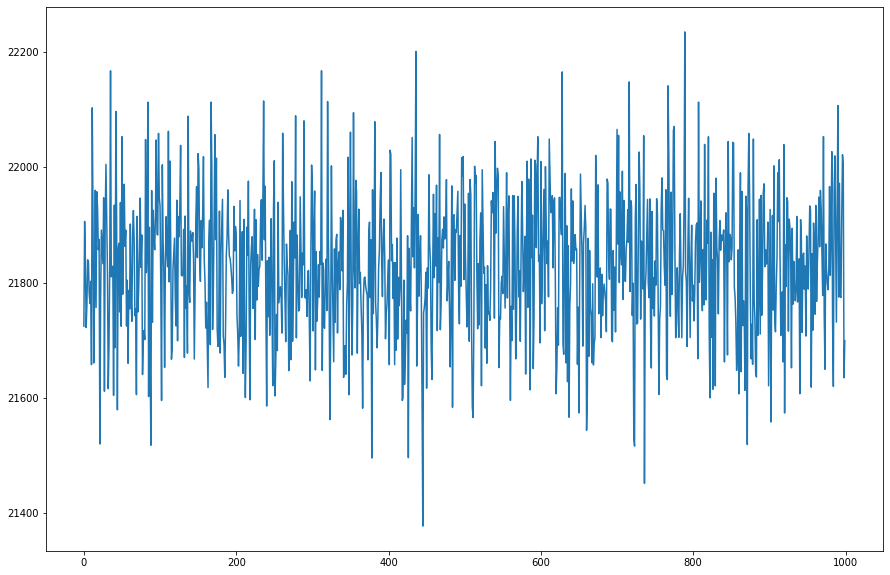

In [129]:
learned_params = train(samples, num_steps=1000, num_obs=2000, model=ProposedModel, guide=autodelta)

In [130]:
learned_params

{'AutoDelta.lambda1': array(4.3359364e-07, dtype=float32),
 'AutoDelta.lambda2': array(-0.14422993, dtype=float32),
 'AutoDelta.lambda3': array(-0.80747616, dtype=float32),
 'AutoDelta.lambda4': array(0.83882356, dtype=float32),
 'AutoDelta.lambda5': array(0.83495915, dtype=float32),
 'AutoDelta.lambda6': array(0.15217298, dtype=float32),
 'AutoDelta.lambda7': array(-0.8376456, dtype=float32),
 'AutoDelta.lambda8': array(-7.9939855e-10, dtype=float32)}

In [131]:
for i in range(1, 9):
    learned_params[f'lambda{i}'] = learned_params.pop(f'AutoDelta.lambda{i}')
    learned_params[f'lambda{i}'] = float(learned_params[f'lambda{i}'])
learned_params

{'lambda1': 4.33593640991603e-07,
 'lambda2': -0.1442299336194992,
 'lambda3': -0.8074761629104614,
 'lambda4': 0.8388235569000244,
 'lambda5': 0.8349591493606567,
 'lambda6': 0.1521729826927185,
 'lambda7': -0.8376455903053284,
 'lambda8': -7.993985473575549e-10}

# Twin-World Counterfactuals 

1. Abduction: Predict the ‘state of the world’ (the exogenous noise, ✏) that is compatible with
the observations, x, i.e. infer PG(✏|x).

2. Action: Perform an intervention (e.g. do(xk := xek)) corresponding to the desired manipulation, resulting in a modified SCM Ge = Gx;do(xek) = (Se, PG(✏|x)).
    
3. Prediction: Compute the quantity of interest based on the distribution entailed by the counterfactual SCM, PG(x).

In [152]:
samples.iloc[1], sample_noise.iloc[2]

(A    0.000000
 R    0.873463
 T    3.079657
 Y    1.000000
 Name: 1, dtype: float64,
 u1    0.739980
 u2    0.116692
 u3    1.111096
 u4    0.080837
 Name: 2, dtype: float64)

In [148]:
# Get sample
obs_data = {k.lower(): torch.tensor(samples.iloc[2][k]) for k in ['A', 'R', 'T', 'Y']} 
obs = {**obs_data, **learned_params}

# Infer noise/state of the world
exogenous = infer_exogenous(obs, ProposedModel)

# Generate counterfactual
counterfactual(ProposedModel, obs, learned_params)

In [172]:
print(counterfactual(ProposedModel, obs, learned_params))

None


In [173]:
def infer_exogenous(obs, model):
    input_obs = torch.tensor(np.array([[obs[k] for k in ['a', 'r', 't', 'y']]]))
    
    cond_sample = pyro.condition(lambda: model(input_obs), obs)
    cond_trace = pyro.poutine.trace(cond_sample).get_trace()
    
    exogenous = {k: cond_trace.nodes[k]['value'] for k in  ['u1', 'u2', 'u3', 'u4']}
    return exogenous


def counterfactual(model, obs, learned_params):
    # Infer state of world
    input_obs = torch.tensor(np.array([[obs[k] for k in ['a', 'r', 't', 'y']]]))
    exogenous = infer_exogenous(obs, model)
    exogenous_learned = {**exogenous, **learned_params}
    
    # Find opposite A value
    cf_a = 0 if input_obs.numpy()[0][0] == 1. else 1.
    condition = {'a': torch.tensor(cf_a)}
    
    # Compute counterfactual
    state_of_world = pyro.poutine.condition(lambda: model(input_obs), data=exogenous_learned)
    counter = pyro.poutine.do(state_of_world, data=condition)()
    return counter

In [250]:
cf_a = 0 if input_obs.numpy()[0][0] == 1. else 1.
condition = {'a': torch.tensor(cf_a)}

In [241]:
input_obs = torch.tensor(np.array([[obs[k] for k in ['a', 'r', 't', 'y']]]))
state_of_world = pyro.poutine.condition(lambda: ProposedModel(input_obs), data={**exogenous, **learned_params}) 

In [247]:
counter = pyro.poutine.do(state_of_world, data=condition)()
counter

In [248]:
cf_trace = pyro.poutine.trace(counter).get_trace()

In [249]:
cf_trace.nodes

OrderedDict()

In [274]:
def ProposedModelSmall(data, gamma_shift=0., C=0.):
    gamma_shift = torch.tensor(gamma_shift)
    C = torch.tensor(C)

    lambda1 = pyro.sample("lambda1", dist.Normal(0., 1.))
    lambda2 = pyro.sample("lambda2", dist.Normal(0., 1.))
    lambda3 = pyro.sample("lambda3", dist.Normal(0., 1.))
    lambda4 = pyro.sample("lambda4", dist.Normal(0., 1.))
    
    with pyro.plate("data", data.size(0)):
        u1 = pyro.sample("u1", dist.Normal(torch.tensor(0.), torch.tensor(0.6)))
        u2 = pyro.sample("u2", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
        u3 = pyro.sample("u3", dist.Normal(torch.tensor(0.), torch.tensor(0.9)))
        
        a_prob = torch.sigmoid(gamma_shift*lambda1*C + u1)
        a_val = pyro.sample("a", dist.Bernoulli(probs=a_prob), obs=data[:,0])

        r_val = pyro.sample("r", dist.Normal(lambda2*a_val + u2, 1.), obs=data[:,1]) 

        y_prob = torch.sigmoid(lambda3*a_val + lambda4*r_val + u3)
        y_val = pyro.sample("y", dist.Bernoulli(probs=y_prob), obs=data[:,2])

In [275]:
autodelta = AutoDelta(pyro.poutine.block(ProposedModelSmall, hide=["u1", "u2", "u3"]))

100%|██████████| 1000/1000 [00:04<00:00, 202.31it/s]


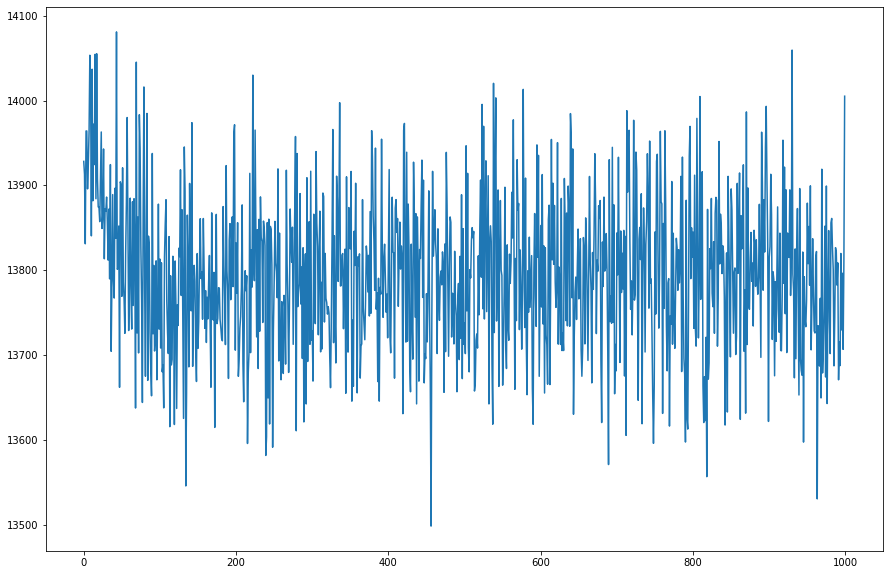

In [276]:
def train(data, num_steps, num_obs, model, guide):
    data = torch.tensor(data.values)
    
    pyro.clear_param_store()
    loss_func = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), loss=loss_func)
    
    losses = []
    for i in tqdm(range(num_steps)):
        loss = svi.step(data)
        losses.append(loss)
        
    plt.figure()
    plt.plot(losses)
    plt.show()
    
    posterior_params = {k: np.array(v.data) for k, v in pyro.get_param_store().items()}
    return posterior_params

learned_params = train(samples[['A', 'R', 'Y']], num_steps=1000, num_obs=2000, model=ProposedModelSmall, guide=autodelta)

In [337]:
def infer_exogenous_small(obs, model):
    input_obs = torch.tensor(np.array([[obs[k] for k in ['a', 'r', 'y']]]))
    
    cond_sample = pyro.condition(lambda: model(input_obs), obs)
    cond_trace = pyro.poutine.trace(cond_sample).get_trace()
    
    exogenous = {k: cond_trace.nodes[k]['value'] for k in  ['u1', 'u2', 'u3']}
    return exogenous


def counterfactual_small(model, obs, learned_params):
    # Infer state of world (ie learn noise)
    input_obs = torch.tensor(np.array([[obs[k] for k in ['a', 'r', 'y']]]))
    exogenous = infer_exogenous(obs, model)
    print('\nExogenous state of world learned\n', exogenous)
    
    exogenous_learned = {**exogenous, **learned_params}
    
    # Find counterfactual A value (a') for this sample
    cf_a = 0 if input_obs.numpy()[0][0] == 1. else 1.
    
    # Compute counterfactual sample
    state_of_world = pyro.poutine.condition(lambda: model(input_obs), data=exogenous_learned)
    cf = pyro.poutine.do(pyro.poutine.condition(lambda: model(input_obs), data=exogenous_learned), data={'a': torch.tensor(cf_a)})()
    
    tr = pyro.poutine.trace(cf).get_trace()
    tr_state = pyro.poutine.trace(state_of_world).get_trace()
    return cf, cf_a, tr, tr_state

In [342]:
# Get sample
obs_data = {k.lower(): torch.tensor(samples.iloc[0][k]) for k in ['A', 'R', 'Y']} 
obs = {**obs_data, **learned_params}
print('Observed sample and learned lambdas')
print("\n".join("{}\t{}".format(k, v) for k, v in obs.items()))

# Infer noise/state of the world and generate counterfactual
cf, cf_a, tr, tr_state= counterfactual_small(ProposedModelSmall, obs, learned_params)
print('\nCounterfactual', cf)
print('\nCounterfactual A=a_prime', cf_a)

Observed sample and learned lambdas
a	1.0
r	1.2587478160858154
y	0.0
AutoDelta.lambda1	8.679151808881061e-24
AutoDelta.lambda2	-0.15230709314346313
AutoDelta.lambda3	-0.8194252848625183
AutoDelta.lambda4	0.849686861038208

Exogenous state of world learned
 {'u1': tensor([-1.2517]), 'u2': tensor([0.0948]), 'u3': tensor([-0.3493])}

Counterfactual None

Counterfactual A=a_prime 0


In [329]:
tr.nodes

OrderedDict()

In [330]:
tr_state.nodes

OrderedDict([('_INPUT',
              {'name': '_INPUT', 'type': 'args', 'args': (), 'kwargs': {}}),
             ('lambda1',
              {'type': 'sample',
               'name': 'lambda1',
               'fn': Normal(loc: 0.0, scale: 1.0),
               'is_observed': False,
               'args': (),
               'kwargs': {},
               'value': tensor(0.6082),
               'infer': {},
               'scale': 1.0,
               'mask': None,
               'cond_indep_stack': (),
               'done': True,
               'stop': False,
               'continuation': None}),
             ('lambda2',
              {'type': 'sample',
               'name': 'lambda2',
               'fn': Normal(loc: 0.0, scale: 1.0),
               'is_observed': False,
               'args': (),
               'kwargs': {},
               'value': tensor(0.4917),
               'infer': {},
               'scale': 1.0,
               'mask': None,
               'cond_indep_stack': (),